In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    df_pca = f.transform(data)
    return loadings , df_pca, f

## Reading Data

In [3]:
bike_pca = pd.read_csv("../PCA/bike_agg_with_season_no.csv")
bike_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       353 non-null    int64  
 1   date             353 non-null    object 
 2   rent_count       353 non-null    int64  
 3   temperature      353 non-null    float64
 4   rainfall         353 non-null    float64
 5   snowfall         353 non-null    int64  
 6   wind_speed       353 non-null    float64
 7   visibility       353 non-null    int64  
 8   solar_radiation  353 non-null    float64
 9   dewpoint_temp    353 non-null    float64
 10  humidity         353 non-null    float64
 11  season           353 non-null    object 
 12  holiday          353 non-null    object 
 13  season_no        353 non-null    int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 38.7+ KB


In [4]:
bike2 = bike_pca.copy()
bike2_y = bike2.rent_count
bike2_cat = bike2.iloc[:, [12, 11]]
bike2_num = bike2.drop(['Unnamed: 0', 'date', 'season', 'holiday', 'season_no', 'rent_count'], axis = 1, inplace = False)

## Splitting Data into Train vs Test

In [5]:
train_y = bike2_y.iloc[:282]
train_cat = bike2_cat.iloc[:282, :]
train_num = bike2_num.iloc[:282, :]

test_y = bike2_y.iloc[282:]
test_cat = bike2_cat.iloc[282:, :]
test_num = bike2_num.iloc[282:, :]

## Standardisation for Numeric Data

In [6]:
colnames = list(train_num.columns)
scaler = StandardScaler(with_mean = True, with_std = True)

train_num_std = pd.DataFrame(scaler.fit_transform(train_num))
train_num_std.columns = colnames

In [7]:
train_num_std.describe()

,temperature,rainfall,snowfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,2.820000e+02,2.820000e+02,2.820000e+02,2.820000e+02,2.820000e+02,2.820000e+02,2.820000e+02,282.000000
mean,-1.511793e-16,2.519655e-17,-7.558965e-17,-1.511793e-16,5.669224e-17,-5.039310e-17,-1.511793e-16,0.000000
std,1.001778e+00,1.001778e+00,1.001778e+00,1.001778e+00,1.001778e+00,1.001778e+00,1.001778e+00,1.001778
min,-2.188409e+00,-3.038831e-01,-2.274986e-01,-2.500350e+00,-2.189221e+00,-8.320321e-01,-2.224636e+00,-2.145200
25%,-9.043145e-01,-3.038831e-01,-2.274986e-01,-7.246055e-01,-8.876115e-01,-8.320321e-01,-7.567511e-01,-0.778422
50%,1.813105e-01,-3.038831e-01,-2.274986e-01,-1.570996e-01,3.177808e-01,-4.776015e-01,1.033102e-01,-0.091258
75%,8.461814e-01,-2.438389e-01,-2.274986e-01,4.287130e-01,9.396314e-01,6.935604e-01,8.538932e-01,0.656317
max,1.618226e+00,7.341740e+00,7.548819e+00,3.357776e+00,9.850675e-01,2.712274e+00,1.481861e+00,2.385555


## Factor Analysis

The Factor Analysis is performed in another notebook, here we just imitate the results obtained from that analysis.

In [8]:
pca_label, df_pca_array, ff = evaluate_pcs(2, train_num_std[colnames])
pca_label

,PC1,PC2
temperature,0.924101,
rainfall,,0.688546
snowfall,,
wind_speed,,
visibility,,-0.727093
solar_radiation,0.853915,
dewpoint_temp,0.837048,
humidity,,0.889825


In [9]:
pca_cols = pd.DataFrame(df_pca_array, columns =['heat_effect', 'rain_effect'])
pca_cols.head()

,heat_effect,rain_effect
0,-0.864451,-0.955283
1,-0.700765,-0.114432
2,-0.846452,1.429332
3,-0.931675,-1.265709
4,-0.845783,-0.684984


In [10]:
train_cat.head()

,holiday,season
0,No Holiday,Winter
1,No Holiday,Winter
2,No Holiday,Winter
3,No Holiday,Winter
4,No Holiday,Winter


## One-Hot Encoding

In [11]:
encoder = OneHotEncoder(handle_unknown = "ignore")
train_cat_onehot = encoder.fit_transform(train_cat)
train_cat_onehot = pd.DataFrame(train_cat_onehot.A)

In [12]:
train_cat_onehot.columns = encoder.get_feature_names()
train_cat_onehot.head()

,x0_Holiday,x0_No Holiday,x1_Autumn,x1_Spring,x1_Summer,x1_Winter
0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0


In [13]:
train_X = pd.concat([train_cat_onehot, pca_cols, train_num_std.loc[:, ['snowfall', 'wind_speed']]], axis =1)

In [14]:
train_X.head()

,x0_Holiday,x0_No Holiday,x1_Autumn,x1_Spring,x1_Summer,x1_Winter,heat_effect,rain_effect,snowfall,wind_speed
0,0.0,1.0,0.0,0.0,0.0,1.0,-0.864451,-0.955283,-0.227499,-0.450006
1,0.0,1.0,0.0,0.0,0.0,1.0,-0.700765,-0.114432,-0.227499,-0.157100
2,0.0,1.0,0.0,0.0,0.0,1.0,-0.846452,1.429332,-0.227499,-0.157100
3,0.0,1.0,0.0,0.0,0.0,1.0,-0.931675,-1.265709,-0.227499,2.771963
4,0.0,1.0,0.0,0.0,0.0,1.0,-0.845783,-0.684984,-0.227499,-2.500350


## Model N0

In [15]:
model = RandomForestRegressor(random_state = 42)
np.mean(-1 * cross_val_score(model, train_X, train_y, cv=5, scoring = 'neg_mean_absolute_percentage_error'))

0.30671103840103164

Text(0.5, 0, 'Random Forest Feature Importance')

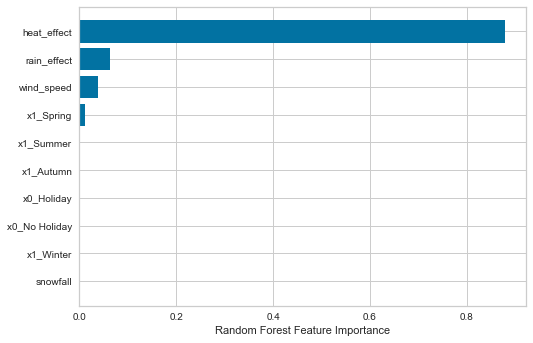

In [16]:
model.fit(train_X, train_y)
model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.barh(train_X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Model N1

In [17]:
train_X1 = train_X.loc[:, ['heat_effect', 'rain_effect', 'wind_speed']]

In [18]:
model1 = RandomForestRegressor(random_state = 42)
np.mean(-1 * cross_val_score(model1, train_X1, train_y, cv=5, scoring = 'neg_mean_absolute_percentage_error'))

0.303714819913237

The absolute error percentage improved, now we will tune the hyperparameters.

## Model N2 (Hyperparameter Tuning)

In [19]:
model1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [66]:
param_space = {
    'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth' : [None, 1, 2, 3, 4, 5],
    'min_samples_split' : [1, 2, 5, 10, 15, 20, 30, 40, 50],
    'min_samples_leaf' : [1, 2, 5, 10, 15, 20, 30, 40, 50],
    'max_features' : ['auto', 'sqrt', 'log2']
}
model2 = RandomForestRegressor()

In [67]:
search = GridSearchCV(model2, param_space, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_percentage_error')
search.fit(train_X1, train_y)

C:\Users\ohjia\pyhome\anaconda3\envs\dsa3101t\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.06396724 -1.03264571
 -1.11081671]
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 40, 50],
                         'min_samples_split': [1, 2, 5, 10, 15, 20, 30, 40, 50],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             scoring='neg_mean_absolute_percentage_error')

In [68]:
search.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 20}

In [69]:
search.best_score_

-0.2983550886625439

In [20]:
model2 = RandomForestRegressor(n_estimators = 20, min_samples_split = 10, min_samples_leaf = 2, max_features = 'auto', max_depth = None, random_state = 3101)
np.mean(-1 * cross_val_score(model2, train_X1, train_y, cv=5, scoring = 'neg_mean_absolute_percentage_error'))

0.30675241670028347

In [31]:
model2.fit(train_X1, train_y)

RandomForestRegressor(min_samples_leaf=2, min_samples_split=10, n_estimators=20,
                      random_state=3101)

## Save Model

In [33]:
joblib.dump(model2, './dt_pca.pkl')

['./dt_pca.pkl']

## Performance on Test Set

In [34]:
model2 = joblib.load('./dt_pca.pkl')

In [44]:
test_num_std = pd.DataFrame(scaler.transform(test_num))
test_num_std.columns = colnames

In [45]:
pca_cols = pd.DataFrame(ff.transform(test_num_std[colnames]), columns = ['heat_effect', 'rain_effect'])
pca_cols.head()

,heat_effect,rain_effect
0,0.430303,-0.393878
1,0.539499,-0.229571
2,0.517260,0.022777
3,0.604894,0.134224
4,0.583186,0.500249


In [46]:
test_cat_onehot = encoder.transform(test_cat)
test_cat_onehot = pd.DataFrame(test_cat_onehot.A)
test_cat_onehot.columns = encoder.get_feature_names()
test_cat_onehot.head()

,x0_Holiday,x0_No Holiday,x1_Autumn,x1_Spring,x1_Summer,x1_Winter
0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0


In [47]:
test_X = pd.concat([test_cat_onehot, pca_cols, test_num_std.loc[:, ['snowfall', 'wind_speed']]], axis = 1)
test_X1 = test_X.loc[:, ['heat_effect', 'rain_effect', 'wind_speed']]

In [48]:
test_pred = model2.predict(test_X1)

In [49]:
np.mean(np.abs(test_pred - test_y) / test_y)

0.381294274286123

Final test set error percentage is quite high.